In [1]:
# Show plots as part of the notebook (this is a Jupyter-specific operation)
%matplotlib inline
import time
import matplotlib.pyplot as plt
import requests
import xmltodict
# Standard library packages
import os

# Import Pandas and Seaborn
import pandas as pd
import seaborn as sns
import numpy as np

# Import Biopython tools for running local BLASTX
from Bio.Blast.Applications import NcbiblastxCommandline
from Bio.Blast.Applications import NcbiblastnCommandline

#For execution time tracking
from datetime import datetime
from pytz import timezone

In [2]:
now_time = datetime.now(timezone('America/Chicago'))
print(now_time.strftime('%I:%M:%S %p'))

11:26:15 AM


In [3]:
%%time
df = pd.read_csv('01_db_blastn_July142020_filtered_1e-20_99perc-id_subj.csv')

CPU times: user 147 ms, sys: 23.4 ms, total: 170 ms
Wall time: 170 ms


In [4]:
df['subject'].nunique()

6552

In [5]:
df = df['subject'].value_counts()
df = pd.Series(df)
df

JAGRRH010000013.1    3098
NC_014267.1          1131
MW645084.1           1120
NC_044463.1          1110
NC_014287.1          1109
                     ... 
DQ026683.1              1
HM133102.1              1
DQ026687.1              1
DQ026688.1              1
AY038427.1              1
Name: subject, Length: 6552, dtype: int64

In [6]:
df.to_csv('01_1_July142020_filtered_1e-20_99perc-id_subj_to_7level_taxonomy.csv')

In [7]:
df = pd.read_csv('01_1_July142020_filtered_1e-20_99perc-id_subj_to_7level_taxonomy.csv')

In [8]:
df.head()

,Unnamed: 0,subject
0,JAGRRH010000013.1,3098
1,NC_014267.1,1131
2,MW645084.1,1120
3,NC_044463.1,1110
4,NC_014287.1,1109


In [9]:
df.columns.values[0] = "subject"
df.columns.values[1] = "count"

In [10]:
df.to_csv('01_1_July142020_filtered_1e-20_99perc-id_subj_to_7level_taxonomy.csv', index= False)

In [11]:
df = pd.read_csv('01_1_July142020_filtered_1e-20_99perc-id_subj_to_7level_taxonomy.csv')

In [12]:
df.head()

,subject,count
0,JAGRRH010000013.1,3098
1,NC_014267.1,1131
2,MW645084.1,1120
3,NC_044463.1,1110
4,NC_014287.1,1109


## Retrieving (efetch) taxonomy heirarchy from NCBI

In [13]:
base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/{}"
db = "nuccore"

In [14]:
def get_taxon_name(tax_id):
    try:
        efetch = "efetch.fcgi?db={}&id={}&rettype=json".format(db, tax_id)
        efetch_response = requests.get(base_url.format(efetch))
        efetch_dict = xmltodict.parse(efetch_response.content)
        Definition = efetch_dict['GBSet']['GBSeq']['GBSeq_definition']
        Definition = Definition.split(',')
        Definition = Definition[0]
        time.sleep(0.5)
    except:
        Definition = tax_id
        pass
 
    return Definition

In [15]:
get_taxon_name ('NC_016703.1')

'Phaeocystis antarctica plastid'

In [16]:
def get_7level_taxonomy(tax_id):
    try:   
        efetch = "efetch.fcgi?db={}&id={}&rettype=json".format(db, tax_id)
        efetch_response = requests.get(base_url.format(efetch))
        efetch_dict = xmltodict.parse(efetch_response.content)
        GBSeq_taxonomy = efetch_dict['GBSet']['GBSeq']['GBSeq_taxonomy']
#        GBSeq_taxonomy_class = GBSeq_taxonomy.split("; ")
#        GBSeq_taxonomy_class = GBSeq_taxonomy_class[2]
        time.sleep(0.5)
    except:
        GBSeq_taxonomy = tax_id
        pass
    
    return GBSeq_taxonomy

In [17]:
get_7level_taxonomy ('NC_016703.1')

'Eukaryota; Haptophyceae; Phaeocystales; Phaeocystaceae; Phaeocystis'

In [18]:
df.head()

,subject,count
0,JAGRRH010000013.1,3098
1,NC_014267.1,1131
2,MW645084.1,1120
3,NC_044463.1,1110
4,NC_014287.1,1109


In [19]:
df['subject']

0       JAGRRH010000013.1
1             NC_014267.1
2              MW645084.1
3             NC_044463.1
4             NC_014287.1
              ...        
6547           DQ026683.1
6548           HM133102.1
6549           DQ026687.1
6550           DQ026688.1
6551           AY038427.1
Name: subject, Length: 6552, dtype: object

In [20]:
%%time
def enrich_dataset(df):
    taxon_value = df['subject']
    Seven_Level_Taxonomy = get_7level_taxonomy(taxon_value)
    df['7Level_Taxonomy'] = Seven_Level_Taxonomy
    return df

CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 15.7 µs


In [21]:
%%time
df = df.apply(enrich_dataset, axis=1)

CPU times: user 4min 3s, sys: 31.3 s, total: 4min 35s
Wall time: 2h 10min 1s


In [22]:
df.to_csv('04_July142020_filtered_1e-20_99perc-id_subj_to_7level_taxonomy_enriched.csv', index= False)

# Process Taxonomic Levels, Extract Information

In [23]:
df = pd.read_csv('04_July142020_filtered_1e-20_99perc-id_subj_to_7level_taxonomy_enriched.csv')

In [24]:
df['7Level_Taxonomy'].nunique()

2452

In [25]:
df.head(5)

,subject,count,7Level_Taxonomy
0,JAGRRH010000013.1,3098,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...
1,NC_014267.1,1131,Eukaryota; Sar; Alveolata; Dinophyceae; Peridi...
2,MW645084.1,1120,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...
3,NC_044463.1,1110,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...
4,NC_014287.1,1109,Eukaryota; Sar; Alveolata; Dinophyceae; Peridi...


In [26]:
def taxlevel (tax):
    tax = tax.split("; ")
    tax_len = len(tax)
    
    return tax_len

In [27]:
def enrich_dataset(df):
    taxon_level = df['7Level_Taxonomy']
    Seven_Level_Taxonomy = taxlevel(taxon_level)
    df['7Level_Lenght'] = Seven_Level_Taxonomy
    return df

In [28]:
%%time
df = df.apply(enrich_dataset, axis=1)

CPU times: user 925 ms, sys: 8.33 ms, total: 934 ms
Wall time: 932 ms


In [29]:
df.head()

,subject,count,7Level_Taxonomy,7Level_Lenght
0,JAGRRH010000013.1,3098,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10
1,NC_014267.1,1131,Eukaryota; Sar; Alveolata; Dinophyceae; Peridi...,7
2,MW645084.1,1120,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10
3,NC_044463.1,1110,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10
4,NC_014287.1,1109,Eukaryota; Sar; Alveolata; Dinophyceae; Peridi...,7


In [30]:
df['7Level_Lenght'].value_counts()

1     1824
6     1099
2     1073
8      449
9      442
4      398
7      345
10     329
5      221
3      210
11     162
Name: 7Level_Lenght, dtype: int64

In [31]:
df.shape

(6552, 4)

In [32]:
df["Levels"] = df["7Level_Lenght"].replace({11: "11_Levels",
                                           10: "10_Levels",
                                           9: "9_Levels",
                                           8: "8_Levels",
                                           7: "7_Levels",
                                           6: "6_Levels",
                                           5: "5_Levels",
                                           4: "4_Levels",
                                           3: "3_Levels",
                                           2: "2_Levels",
                                           1: "1_Level",
                                           })

In [33]:
df.head()

,subject,count,7Level_Taxonomy,7Level_Lenght,Levels
0,JAGRRH010000013.1,3098,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10,10_Levels
1,NC_014267.1,1131,Eukaryota; Sar; Alveolata; Dinophyceae; Peridi...,7,7_Levels
2,MW645084.1,1120,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10,10_Levels
3,NC_044463.1,1110,Eukaryota; Sar; Stramenopiles; Ochrophyta; Bac...,10,10_Levels
4,NC_014287.1,1109,Eukaryota; Sar; Alveolata; Dinophyceae; Peridi...,7,7_Levels


<AxesSubplot:>

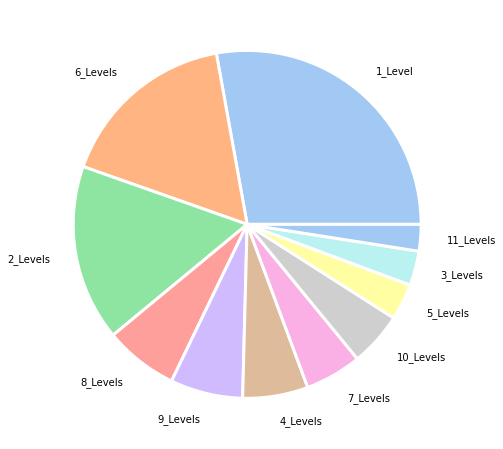

In [34]:
plt.rcParams["figure.figsize"] = (30,8)
colors = sns.color_palette('pastel')[0:11]
df['Levels'].value_counts().plot.pie(labeldistance=1.15, 
                                     wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, 
                                     colors=colors,
                                     ylabel='')

<AxesSubplot:>

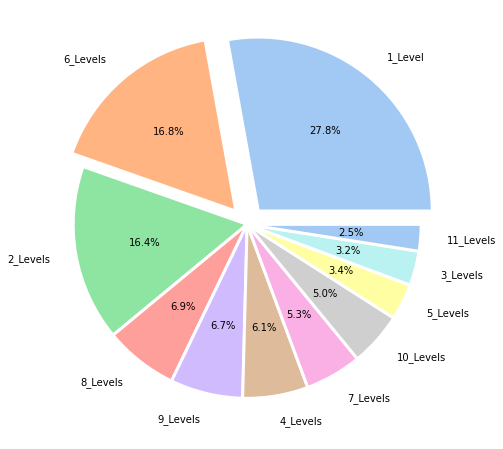

In [35]:
plt.rcParams["figure.figsize"] = (30,8)
colors = sns.color_palette('pastel')[0:11]
explode = (0.1, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
df['Levels'].value_counts().plot.pie(labeldistance=1.15, 
                                     wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, 
                                     colors=colors,
                                     ylabel='',
                                     autopct='%1.1f%%',
                                     explode = explode)

<AxesSubplot:>

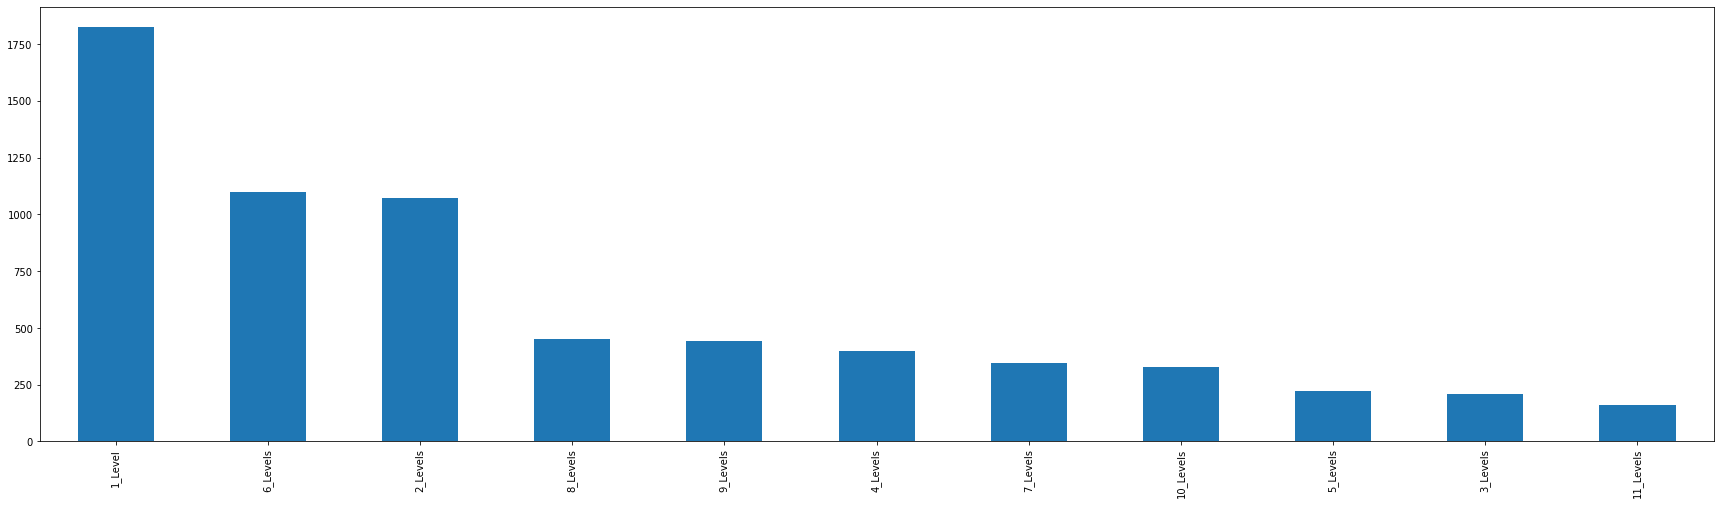

In [36]:
df['Levels'].value_counts().plot.bar()

##### Saving the count of taxonomic levels of each subject (blasted accession numbers from Nucleotide database of NCBI)

In [37]:
df.to_csv('05_July142020_filtered_1e-20_99perc-id_subj_to_7level_taxonomy_enriched.csv', index= False)